<a href="https://colab.research.google.com/github/dajebbar/FreeCodeCamp-python-data-analysis/blob/main/ML3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Prepare data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
!pip install -U opendatasets  --quiet

In [3]:
import opendatasets as od
import os 

url = 'https://www.kaggle.com/c/titanic/data'
data_dir = od.download(url)

100%|██████████| 34.1k/34.1k [00:00<00:00, 11.4MB/s]


Extracting archive ./titanic/titanic.zip to ./titanic


In [31]:
train_df = pd.read_csv('./titanic/train.csv')
test_df = pd.read_csv('./titanic/test.csv')

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [32]:
data_train = train_df.drop(columns=['Survived', 'PassengerId', 'Name', 
                                    'Ticket', 'Cabin'],
                           axis=1)
data_test = test_df.drop(columns=['PassengerId', 'Name', 
                                    'Ticket', 'Cabin'],
                           axis=1)
target = train_df.Survived

In [11]:
data_train.isna().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [12]:
target.isna().sum()

0

In [13]:
target.value_counts(normalize=True) * 100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

In [14]:
data_train.shape, data_test.shape

((891, 7), (418, 7))

In [15]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


# Variables inspection

In [16]:
!pip install -U yellowbrick --quiet

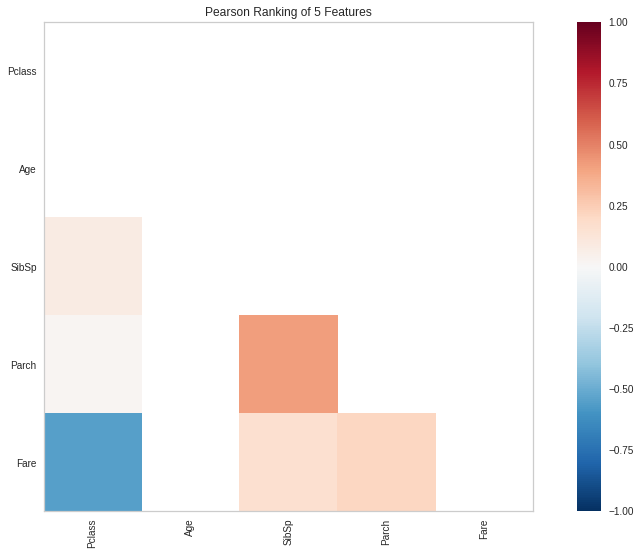

In [33]:
# redundancy between variables
# correlations between pairs of variables

from sklearn.compose import make_column_selector as selector
from yellowbrick.features import Rank2D

num_features = selector(dtype_include='number')(data_train)
cat_features = selector(dtype_include='object')(data_train)
_, r2d = plt.subplots(figsize=(14, 9))
r2d = Rank2D()
r2d.fit_transform(data_train[num_features])
r2d.show()

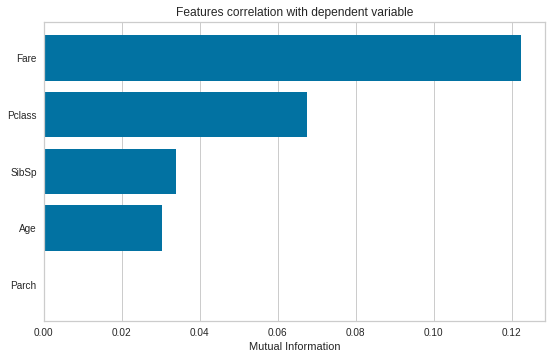

In [18]:
# pertinence with target

from yellowbrick.target import FeatureCorrelation
fc = FeatureCorrelation(method='mutual_info-classification', sort=True)
fc.fit(data_train[num_features].fillna(value=data_train[num_features].mean()), 
       target, discrete_features=False)
fc.show()

# Modelisation

In [34]:
print(num_features)
print(cat_features)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Sex', 'Embarked']


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_cv, y_train, y_cv = train_test_split(
    data_train, target, test_size=.33,
    random_state=42, stratify=target,
)

In [21]:
# Verify distributions
print(y_train.value_counts(normalize=True))
print(y_cv.value_counts(normalize=True))

0    0.615772
1    0.384228
Name: Survived, dtype: float64
0    0.616949
1    0.383051
Name: Survived, dtype: float64


In [36]:
# Impute data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X_tr = X_train.copy()
X_validate = X_cv.copy()

imputer = IterativeImputer()

imputer.fit(X_tr[num_features])

X_tr[num_features] = imputer.fit_transform(X_tr[num_features])
X_validate[num_features] = imputer.transform(X_validate[num_features])

data_test[num_features] = imputer.transform(data_test[num_features])

In [37]:
X_tr.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
381,3.0,female,1.0,0.0,2.0,15.7417,C
325,1.0,female,36.0,0.0,0.0,135.6333,C
125,3.0,male,12.0,1.0,0.0,11.2417,C
597,3.0,male,49.0,0.0,0.0,0.0000,S
85,3.0,female,33.0,3.0,0.0,15.8500,S


In [24]:
X_validate[num_features].isna().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64

In [38]:
# Normalize data
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
)

scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_tr[num_features] = scaler.fit_transform(X_tr[num_features])
X_validate[num_features] = scaler.transform(X_validate[num_features])

data_test[num_features] = scaler.transform(data_test[num_features])

In [39]:
X_tr.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
381,0.819889,female,-2.121062,-0.472568,1.911961,-0.317787,C
325,-1.587273,female,0.463455,-0.472568,-0.447312,2.202523,C
125,0.819889,male,-1.308785,0.566733,-0.447312,-0.412384,C
597,0.819889,male,1.423418,-0.472568,-0.447312,-0.648702,S
85,0.819889,female,0.241925,2.645335,-0.447312,-0.315510,S


In [47]:
data = data_train[cat_features].fillna('Unknown')
encoder.fit(data)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [48]:
encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S', 'Unknown'], dtype=object)]

In [49]:
encoded_cols = list(encoder.get_feature_names_out(cat_features))
print(encoded_cols)

['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_Unknown']


In [51]:
X_tr[encoded_cols] = encoder.transform(X_tr[cat_features])
X_validate[encoded_cols] = encoder.transform(X_validate[cat_features])

data_test[encoded_cols] = encoder.transform(data_test[cat_features].fillna('Unknown'))

In [54]:
pd.set_option('display.max_columns', None)
X_validate.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown
371,0.819889,male,-0.865725,0.566733,-0.447312,-0.512150,S,0.0,1.0,0.0,0.0,1.0,0.0
241,0.819889,female,-0.429571,0.566733,-0.447312,-0.322868,Q,1.0,0.0,0.0,1.0,0.0,0.0
472,-0.383692,female,0.241925,0.566733,1.911961,-0.065354,S,1.0,0.0,0.0,0.0,1.0,0.0
824,0.819889,male,-2.047218,3.684636,0.732324,0.185591,S,0.0,1.0,0.0,0.0,1.0,0.0
743,0.819889,male,-0.422665,0.566733,-0.447312,-0.310255,S,0.0,1.0,0.0,0.0,1.0,0.0


# Various Family

In [57]:
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X = pd.concat([X_tr, X_validate])[num_features + encoded_cols]
y = pd.concat([y_train, y_cv])

models = [
          DummyClassifier,
          LogisticRegression,
          DecisionTreeClassifier,
          KNeighborsClassifier,
          GaussianNB,
          SVC,
          RandomForestClassifier,
          XGBClassifier,
]

for model in models:
  cls = model()
  fold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
  cv_results = cross_validate(cls,
                              X,
                              y,
                              cv=fold,
                              scoring='roc_auc',
                              n_jobs=-1)
  
  print(f"{model.__name__:22} AUC: "
  f"{cv_results['test_score'].mean():.3f} STD: {cv_results['test_score'].std():.2f}"
  )


DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.851 STD: 0.03
DecisionTreeClassifier AUC: 0.774 STD: 0.03
KNeighborsClassifier   AUC: 0.846 STD: 0.03
GaussianNB             AUC: 0.827 STD: 0.02
SVC                    AUC: 0.852 STD: 0.03
RandomForestClassifier AUC: 0.865 STD: 0.02
XGBClassifier          AUC: 0.867 STD: 0.03
